<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

Cloning into 'deepul'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 270 (delta 51), reused 32 (delta 32), pack-reused 188 (from 2)
Receiving objects: 100% (270/270), 94.71 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22739 sha256=7044cea0ebe4ec4e0b7282a61f91725046c9accca15d374cdfde57e35533b8ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-dxj6wsif/wheels/ef/ca/e6/838f85393ab50f0d590acc4f5cfa805863e523ebaee1b400c4
Successfully built deepul


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


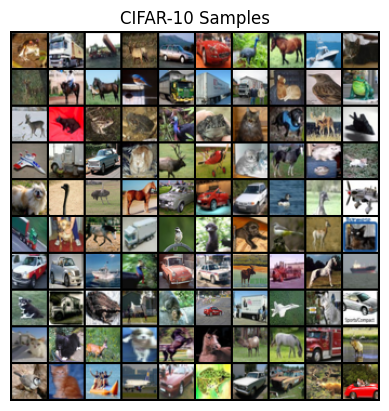

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 150MB/s]


8.19kB [00:00, 529kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
tensor(0.)


In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
visualize_q2_data()
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS
loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

In [ ]:
ptu.set_gpu_mode(True)

# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset.

Execute the cell below to visualize our datasets.

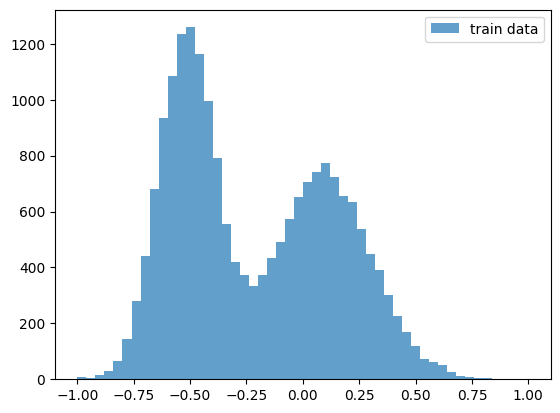

In [ ]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution.
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

In [ ]:
class descriminator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    out = self.layers(x)
    return out

class generator(nn.Module):
  def __init__(self, hidden_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, hidden_dim),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_dim, 1),
        nn.Tanh()
    )

  def forward(self, x):
    out = self.layers(x)
    return out

### Solution

In [ ]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    sample_1_epoch = None
    dis_1_epoch = None
    dis_loss = []
    sample_end = None
    dis_loss_end = None
    epoch = 15
    lr = 1e-3
    bs = 64
    hidden_dim = 128
    des_repeat = 4
    gen = generator(hidden_dim)
    dis = descriminator(hidden_dim)
    optim_gen = torch.optim.Adam(gen.parameters(), lr=lr)
    optim_des = torch.optim.Adam(dis.parameters(), lr=lr)
    bce = nn.BCELoss()
    train_data = torch.from_numpy(train_data)
    train_data_set = torch.utils.data.TensorDataset(train_data)
    train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=bs, shuffle=True)
    from tqdm import tqdm
    for e in range(epoch):
      loop = tqdm(train_data_loader)
      for data in loop:
        optim_gen.zero_grad()
        real_data = data[0].float()
        z = torch.randn(bs, hidden_dim)
        fake_data = gen(z)
        # train_des
        for i in range(des_repeat):
          optim_des.zero_grad()
          dis_real_data = dis(real_data)
          real_label = torch.ones(real_data.shape[0],).unsqueeze(dim=1)
          dis_fake_data = dis(fake_data.detach()) #detach or not?
          fake_label = torch.zeros(dis_fake_data.shape[0],).unsqueeze(dim=1)
          # print(dis_real_data.shape, real_label.shape)
          real_loss = bce(dis_real_data, real_label)
          fake_loss = bce(dis_fake_data, fake_label)
          total_loss = real_loss + fake_loss
          total_loss.backward()
          optim_des.step()
          loop.set_description(f'Epoch [{e}/{epoch}]')
        dis_loss.append(total_loss.item() / des_repeat)
        # train_gen

        dis_fake_data = dis(fake_data)
        real_label = torch.ones(bs,).unsqueeze(dim = 1)
        loss_gen = bce(dis_fake_data, real_label)
        loss_gen.backward()
        optim_gen.step()
        loop.set_postfix({'loss_des':total_loss.item(), 'loss_gen':loss_gen.item()})


      if e == 0:
        z = torch.randn(5000, hidden_dim)
        sample_1_epoch = gen(z).squeeze().detach().cpu().numpy()
        linear_1_epoch = torch.from_numpy(np.linspace(-1, 1, 1000)).float().unsqueeze(1)
        print(linear_1_epoch.shape)
        dis_1_epoch = dis(linear_1_epoch).detach().squeeze().cpu().numpy()
    z = torch.randn(5000, hidden_dim)
    sample_end = gen(z).detach().squeeze().cpu().numpy()
    linear_1_epoch = torch.from_numpy(np.linspace(-1, 1, 1000)).float().unsqueeze(1)
    dis_loss_end = dis(linear_1_epoch).detach().squeeze().cpu().numpy()
    linear_samples = np.linspace(-1, 1, 1000)
    print(sample_1_epoch.shape, dis_1_epoch.shape)
    return np.array(dis_loss), sample_1_epoch, linear_samples, dis_1_epoch, sample_end, linear_samples, dis_loss_end


In [ ]:
#different z (original ver)
def q1_a(train_data):
  """
  train_data: An (20000, 1) numpy array of floats in [-1, 1]
  code
  Code
  Returns
  - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
  - a numpy array of size (5000,) of samples drawn from your model at epoch #1
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
      at each location in the previous array at epoch #1

  - a numpy array of size (5000,) of samples drawn from your model at the end of training
  - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
  - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
      at each location in the previous array at the end of training
  """

  """ YOUR CODE HERE """
  sample_1_epoch = None
  dis_1_epoch = None
  dis_loss = []
  sample_end = None
  dis_loss_end = None
  epoch = 15
  lr = 1e-3
  bs = 64
  hidden_dim = 128
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  des_repeat = 4
  gen = generator(hidden_dim).to(device)
  dis = descriminator(hidden_dim).to(device)
  optim_gen = torch.optim.Adam(gen.parameters(), lr=lr)
  optim_des = torch.optim.Adam(dis.parameters(), lr=lr)
  bce = nn.BCELoss()
  train_data = torch.from_numpy(train_data).to(device)
  train_data_set = torch.utils.data.TensorDataset(train_data)
  train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=bs, shuffle=True)
  from tqdm import tqdm
  for e in range(epoch):
    loop = tqdm(train_data_loader)
    for data in loop:
      optim_gen.zero_grad()
      real_data = data[0].float().to(device)
      # train_des
      for i in range(des_repeat):
        optim_des.zero_grad()
        dis_real_data = dis(real_data)
        real_label = torch.ones(real_data.shape[0],).unsqueeze(dim=1).to(device)
        dis_fake_data = dis(gen(torch.randn(bs, hidden_dim).to(device)).detach()) #detach or not?
        fake_label = torch.zeros(dis_fake_data.shape[0],).unsqueeze(dim=1).to(device)
        # print(dis_real_data.shape, real_label.shape)
        real_loss = bce(dis_real_data, real_label)
        fake_loss = bce(dis_fake_data, fake_label)
        total_loss = real_loss + fake_loss
        total_loss.backward()
        optim_des.step()
        loop.set_description(f'Epoch [{e}/{epoch}]')
      dis_loss.append(total_loss.item() / des_repeat)
      # train_gen
      z = torch.randn(bs, hidden_dim).to(device)
      fake_data = gen(z)
      dis_fake_data = dis(fake_data)
      real_label = torch.ones(bs,).unsqueeze(dim = 1).to(device)
      # loss_gen = bce(dis_fake_data, real_label)
      loss_gen = torch.log(1 - dis_fake_data).mean()
      loss_gen.backward()
      optim_gen.step()
      loop.set_postfix({'loss_des':total_loss.item(), 'loss_gen':loss_gen.item()})


    if e == 0:
      z = torch.randn(5000, hidden_dim).to(device)
      sample_1_epoch = gen(z).squeeze().detach().cpu().numpy()
      linear_1_epoch = torch.from_numpy(np.linspace(-1, 1, 1000)).float().unsqueeze(1).to(device)
      print(linear_1_epoch.shape)
      dis_1_epoch = dis(linear_1_epoch).detach().squeeze().cpu().numpy()
  z = torch.randn(5000, hidden_dim).to(device)
  sample_end = gen(z).detach().squeeze().cpu().numpy()
  linear_1_epoch = torch.from_numpy(np.linspace(-1, 1, 1000)).float().unsqueeze(1).to(device)
  dis_loss_end = dis(linear_1_epoch).detach().squeeze().cpu().numpy()
  linear_samples = np.linspace(-1, 1, 1000)
  print(sample_1_epoch.shape, dis_1_epoch.shape)
  return np.array(dis_loss), sample_1_epoch, linear_samples, dis_1_epoch, sample_end, linear_samples, dis_loss_end

### Results

Epoch [0/15]: 100%|██████████| 313/313 [00:07<00:00, 43.30it/s, loss_des=1.39, loss_gen=-0.674]


torch.Size([1000, 1])


Epoch [14/15]: 100%|██████████| 313/313 [00:06<00:00, 45.01it/s, loss_des=1.37, loss_gen=-0.69]


(5000,) (1000,)


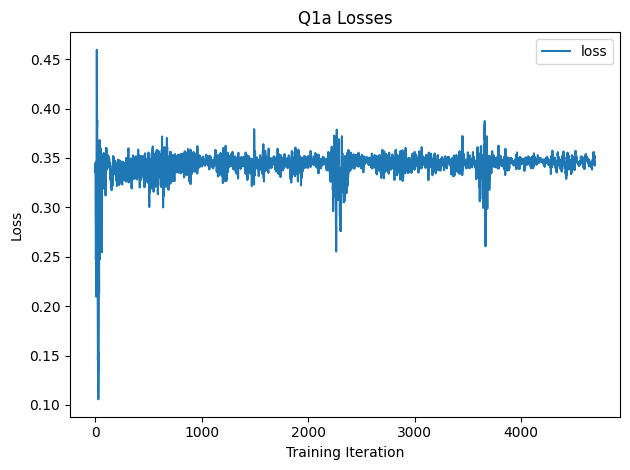

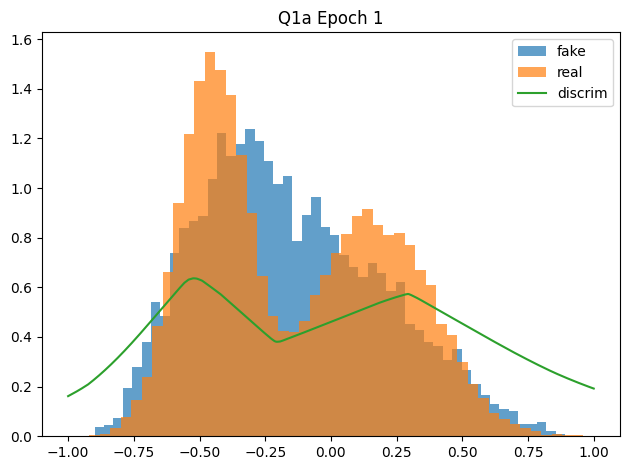

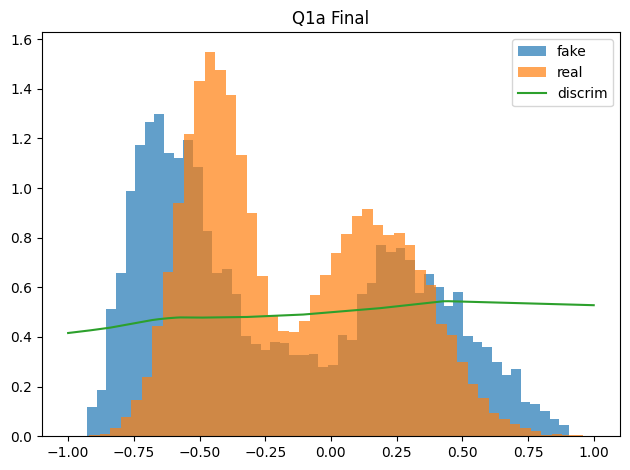

In [ ]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate objectives:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G)} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z)))$$

 ### Solution

In [ ]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid)
        at each location in the previous array at the end of training
    """

    """ YOUR CODE HERE """
    sample_1_epoch = None
    dis_1_epoch = None
    dis_loss = []
    sample_end = None
    dis_loss_end = None
    epoch = 15
    lr = 1e-3
    bs = 64
    hidden_dim = 128
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    des_repeat = 4
    gen = generator(hidden_dim).to(device)
    dis = descriminator(hidden_dim).to(device)
    optim_gen = torch.optim.Adam(gen.parameters(), lr=lr)
    optim_des = torch.optim.Adam(dis.parameters(), lr=lr)
    bce = nn.BCELoss()
    train_data = torch.from_numpy(train_data).to(device)
    train_data_set = torch.utils.data.TensorDataset(train_data)
    train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=bs, shuffle=True)
    from tqdm import tqdm
    for e in range(epoch):
      loop = tqdm(train_data_loader)
      for data in loop:
        optim_gen.zero_grad()
        real_data = data[0].float().to(device)
        # train_des
        for i in range(des_repeat):
          optim_des.zero_grad()
          dis_real_data = dis(real_data)
          real_label = torch.ones(real_data.shape[0],).unsqueeze(dim=1).to(device)
          dis_fake_data = dis(gen(torch.randn(bs, hidden_dim).to(device)).detach()) #detach or not?
          fake_label = torch.zeros(dis_fake_data.shape[0],).unsqueeze(dim=1).to(device)
          # print(dis_real_data.shape, real_label.shape)
          real_loss = bce(dis_real_data, real_label)
          fake_loss = bce(dis_fake_data, fake_label)
          total_loss = real_loss + fake_loss
          total_loss.backward()
          optim_des.step()
          loop.set_description(f'Epoch [{e}/{epoch}]')
        dis_loss.append(total_loss.item() / des_repeat)
        # train_gen
        z = torch.randn(bs, hidden_dim).to(device)
        fake_data = gen(z)
        dis_fake_data = dis(fake_data)
        real_label = torch.ones(bs,).unsqueeze(dim = 1).to(device)
        # loss_gen = bce(dis_fake_data, real_label)
        loss_gen = -torch.log(dis_fake_data).mean()
        loss_gen.backward()
        optim_gen.step()
        loop.set_postfix({'loss_des':total_loss.item(), 'loss_gen':loss_gen.item()})


      if e == 0:
        z = torch.randn(5000, hidden_dim).to(device)
        sample_1_epoch = gen(z).squeeze().detach().cpu().numpy()
        linear_1_epoch = torch.from_numpy(np.linspace(-1, 1, 1000)).float().unsqueeze(1).to(device)
        print(linear_1_epoch.shape)
        dis_1_epoch = dis(linear_1_epoch).detach().squeeze().cpu().numpy()
    z = torch.randn(5000, hidden_dim).to(device)
    sample_end = gen(z).detach().squeeze().cpu().numpy()
    linear_1_epoch = torch.from_numpy(np.linspace(-1, 1, 1000)).float().unsqueeze(1).to(device)
    dis_loss_end = dis(linear_1_epoch).detach().squeeze().cpu().numpy()
    linear_samples = np.linspace(-1, 1, 1000)
    print(sample_1_epoch.shape, dis_1_epoch.shape)
    return np.array(dis_loss), sample_1_epoch, linear_samples, dis_1_epoch, sample_end, linear_samples, dis_loss_end

 ### Results

Epoch [0/15]: 100%|██████████| 313/313 [00:06<00:00, 49.86it/s, loss_des=1.37, loss_gen=0.751]


torch.Size([1000, 1])


Epoch [14/15]: 100%|██████████| 313/313 [00:06<00:00, 45.84it/s, loss_des=1.39, loss_gen=0.677]


(5000,) (1000,)


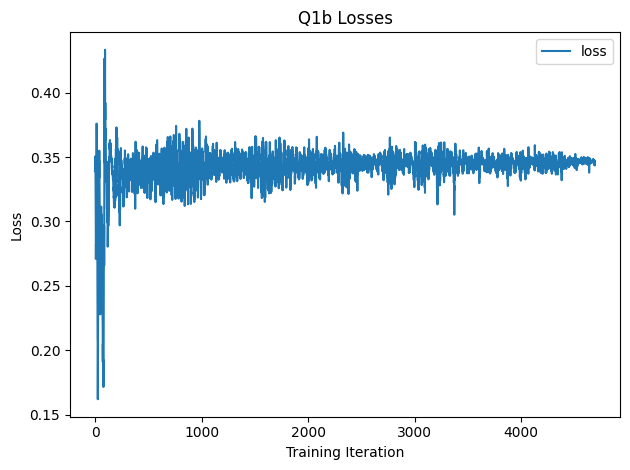

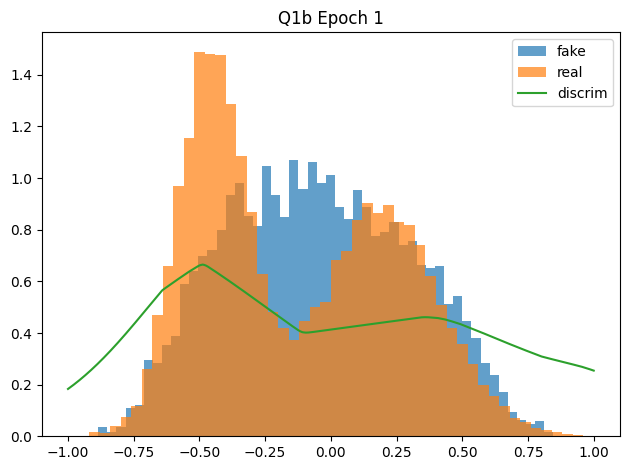

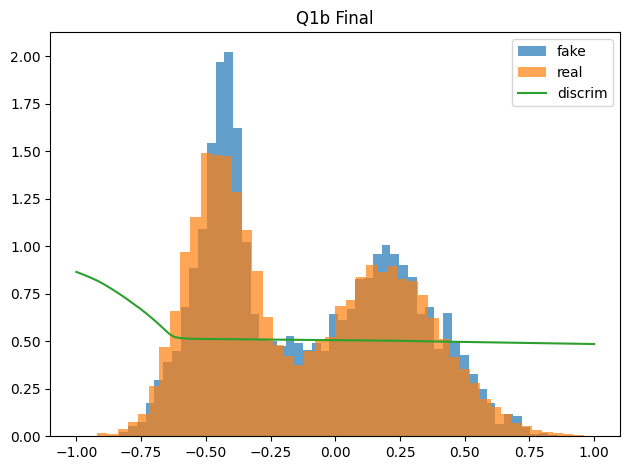

In [ ]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset.

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


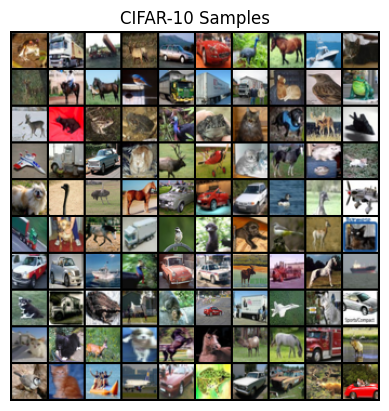

In [ ]:
visualize_q2_data()
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS
loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states.

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training.

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples.

## Solution

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output



class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

In [ ]:
class Upsample_Conv2d(nn.Module):
    """
    一个完整的上采样卷积层:
    1. 使用 DepthToSpace 将 H, W 翻倍，C / 4。 (这里用 PyTorch 内置的 PixelShuffle 更高效)
    2. 应用一个 3x3 卷积。
    """
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), padding=1):
        super().__init__()
        # PyTorch 内置的 DepthToSpace 功能
        self.DepthToSpace = DepthToSpace(block_size=2)
        self.conv = nn.Conv2d(in_dim // 4, out_dim, kernel_size, stride=1, padding=padding)

    def forward(self, x):
        # x 的 shape: (N, C, H, W)
        x = self.DepthToSpace(x) # -> shape: (N, C/4, H*2, W*2)
        x = self.conv(x)          # -> shape: (N, out_dim, H*2, W*2)
        return x

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), padding=1, use_norm=False):
        super().__init__()
        self.space_to_depth = SpaceToDepth(block_size=2)
        if use_norm:
          self.conv = nn.utils.spectral_norm(nn.Conv2d(in_dim * 4, out_dim, kernel_size, stride=1, padding=padding))
        else:
          self.conv = nn.Conv2d(in_dim * 4, out_dim, kernel_size, stride=1, padding=padding)

    def forward(self, x):
        # x 的 shape: (N, C, H, W)
        x = self.space_to_depth(x) # -> shape: (N, C*4, H/2, W/2)
        x = self.conv(x)           # -> shape: (N, out_dim, H/2, W/2)
        return x

# ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
#     _x = x
#     _x = nn.BatchNorm2d(in_dim)(_x)
#     _x = nn.ReLU()(_x)
#     _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
#     _x = nn.BatchNorm2d(n_filters)(_x)
#     _x = nn.ReLU()(_x)
#     residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
#     shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
#     return residual + shortcut
class ResnetBlockUp(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
    super().__init__()
    self.upsample_conv1 = Upsample_Conv2d(n_filters, n_filters, kernel_size)
    self.upsample_conv2 = Upsample_Conv2d(in_dim, n_filters, (1, 1), padding=0)
    self.layers = nn.Sequential(
        nn.BatchNorm2d(in_dim),
        nn.ReLU(),
        nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
        nn.BatchNorm2d(n_filters),
        nn.ReLU()
    )
  def forward(self, x):
      _x = x
      _x = self.layers(_x)
      residual = self.upsample_conv1(_x)
      shortcut = self.upsample_conv2(x)
      return residual + shortcut

class ResnetBlockDown(nn.Module):
  def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256, use_norm=False):
    super().__init__()
    self.upsample_conv1 = Downsample_Conv2d(n_filters, n_filters, kernel_size, use_norm=use_norm)
    self.upsample_conv2 = Downsample_Conv2d(in_dim, n_filters, (1, 1), padding=0, use_norm=use_norm)
    self.layers = nn.Sequential(
        nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
        nn.ReLU()
    )
  def forward(self, x):
      _x = x
      _x = self.layers(_x)
      residual = self.upsample_conv1(_x)
      shortcut = self.upsample_conv2(x)
      return residual + shortcut


class Generator(nn.Module):
  def __init__(self, n_filters=128):
    super().__init__()
    self.linear = nn.Linear(128, 4*4*256)
    self.layers = nn.Sequential(
        ResnetBlockUp(256, n_filters=n_filters),
        ResnetBlockUp(n_filters, n_filters=n_filters),
        ResnetBlockUp(n_filters, n_filters=n_filters),
        nn.BatchNorm2d(n_filters),
        nn.ReLU(),
        nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
        nn.Tanh()
    )
  def forward(self, x):
    x = self.linear(x)
    x = x.reshape(-1, 256, 4, 4)
    x = self.layers(x)
    return x
'''
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
The discriminator (no BatchNorm!).
'''
class Discriminator(nn.Module):
  def __init__(self, n_filters=128):
    super().__init__()
    self.layers = nn.Sequential(
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResnetBlockDown(n_filters, n_filters=n_filters),
        ResnetBlockDown(n_filters, n_filters=n_filters),
        nn.ReLU()
    )
    self.global_sum_pooling = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(n_filters, 1)
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x_ = self.layers(x)
    x_ = self.global_sum_pooling(x_)
    x_ = x_.reshape(-1, 128)
    x_ = self.linear(x_)
    # x_ = self.sigmoid(x_)
    return x_

'''
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
        '''

'\ndef Discriminator(*):\n    def __init__(self, n_filters=128):\n        ResnetBlockDown(3, n_filters=n_filters),\n        ResnetBlockDown(128, n_filters=n_filters),\n        ResBlock(n_filters, n_filters=n_filters),\n        ResBlock(n_filters, n_filters=n_filters),\n        nn.ReLU()\n        global sum pooling\n        nn.Linear(128, 1)\n        '

 ### Models

In [ ]:
# def q2(train_data):
#     """
#     train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

#     Returns
#     - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
#     - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1].
#         The first 100 will be displayed, and the rest will be used to calculate the Inception score.
#     """

#     """ YOUR CODE HERE """
#     # epoch = 128
#     epoch = 640
#     lr = 2e-4
#     bs =256
#     hidden_dim = 128
#     loss = []
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     # device = 'cpu'
#     des_repeat = 1
#     gen = Generator().to(device)
#     dis = Discriminator().to(device)
#     optim_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
#     optim_des = torch.optim.Adam(dis.parameters(), lr=lr, betas=(0.0, 0.9))
#     bce = nn.BCELoss()
#     train_data = torch.from_numpy(train_data[:100]).to(device)
#     train_data_set = torch.utils.data.TensorDataset(train_data)
#     train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=bs, shuffle=True)
#     scheduler_gen = torch.optim.lr_scheduler.LinearLR(
#     optim_gen,
#     start_factor=1.0,
#     end_factor=0.0,
#     total_iters=epoch * len(train_data_loader)
# )
#     scheduler_des = torch.optim.lr_scheduler.LinearLR(
#         optim_des,
#         start_factor=1.0,
#         end_factor=0.0,
#         total_iters=epoch * len(train_data_loader)
#     )
#     from tqdm import tqdm
#     for e in range(epoch):
#       loop = tqdm(train_data_loader)
#       for data in loop:
#         optim_gen.zero_grad()
#         real_data = data[0].float().to(device)
#         # train_des
#         for i in range(des_repeat):
#           optim_des.zero_grad()
#           dis_real_data = dis(real_data)
#           real_label = torch.ones(real_data.shape[0],).unsqueeze(dim=1).to(device)
#           dis_fake_data = dis(gen(torch.randn(bs, hidden_dim).to(device)).detach()) #detach or not?
#           fake_label = torch.zeros(dis_fake_data.shape[0],).unsqueeze(dim=1).to(device)
#           # print(dis_real_data.shape, real_label.shape)
#           # print(dis_real_data)
#           # real_loss = bce(dis_real_data, real_label)
#           # fake_loss = bce(dis_fake_data, fake_label)
#           # total_loss = real_loss + fake_loss
#           total_loss = torch.mean(dis_fake_data) - torch.mean(dis_real_data)
#           total_loss.backward()
#           optim_des.step()
#           loop.set_description(f'Epoch [{e}/{epoch}]')
#         # train_gen
#         z = torch.randn(bs, hidden_dim).to(device)
#         fake_data = gen(z)
#         dis_fake_data = dis(fake_data)
#         real_label = torch.ones(bs,).unsqueeze(dim = 1).to(device)
#         # loss_gen = bce(dis_fake_data, real_label)
#         loss_gen = -torch.mean(dis_fake_data)
#         # loss_gen = -torch.log(dis_fake_data).mean()
#         loss_gen.backward()
#         optim_gen.step()
#         scheduler_des.step()
#         scheduler_gen.step()
#         loop.set_postfix({'loss_des':total_loss.item(), 'loss_gen':loss_gen.item()})
#         loss.append(total_loss.item() / des_repeat)

#     #------SAMPLE------
#     z = torch.randn(1000, hidden_dim).to(device)
#     gen_img = gen(z)
#     samples = gen_img.permute(0, 2, 3, 1).cpu().detach().numpy()
#     return loss, samples

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
from tqdm import tqdm

# 确保你的 Generator 和 Discriminator 类已经定义在这里
# class Generator(nn.Module): ...
# class Discriminator(nn.Module): ... # 记住！最后不要有 Sigmoid

def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """计算 WGAN-GP 的梯度惩罚"""
    # 随机生成一个权重 alpha，用于插值
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # 创建插值图片
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)

    critic_interpolates = critic(interpolates)
    grad_outputs = torch.ones(critic_interpolates.size(), device=device, requires_grad=False)

    # 计算梯度
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.reshape(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1].
    """

    # --- 超参数设置 ---
    num_epochs = 100 # 对于完整数据集，不需要 640 那么多次
    lr = 2e-4
    batch_size = 256 # bs 变量名改为 batch_size 更清晰
    latent_dim = 128
    lambda_gp = 10   # 梯度惩罚的系数
    n_critic = 5     # CRITICAL FIX: Critic 每次更新 5 次

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    critic_losses = []

    # --- 模型和优化器 ---
    gen = Generator().to(device)
    critic = Discriminator().to(device) # 重命名为 critic 更符合 WGAN 术语

    optim_g = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
    optim_c = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

    # --- 数据加载 ---
    # CRITICAL FIX: 使用所有训练数据，而不是前 100 个
    train_tensor = torch.from_numpy(train_data).to(device)
    train_dataset = torch.utils.data.TensorDataset(train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    total_steps = num_epochs * len(train_loader)

    # --- 学习率调度器 ---
    scheduler_g = torch.optim.lr_scheduler.LinearLR(optim_g, start_factor=1.0, end_factor=0.0, total_iters=total_steps)
    scheduler_c = torch.optim.lr_scheduler.LinearLR(optim_c, start_factor=1.0, end_factor=0.0, total_iters=total_steps)

    # --- 训练循环 ---
    gen_iterations = 0
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, leave=True)
        for i, data in enumerate(loop):
            real_images = data[0].float().to(device)
            current_batch_size = real_images.shape[0] # CRITICAL FIX: 使用当前批次大小

            # ====================
            # 训练 Critic
            # ====================
            optim_c.zero_grad()

            # 生成伪造图片
            noise = torch.randn(current_batch_size, latent_dim, device=device)
            fake_images = gen(noise).detach()

            # 计算 Critic 对真实和伪造图片的分数
            real_output = critic(real_images)
            fake_output = critic(fake_images)

            # 计算 WGAN 损失
            wgan_loss = torch.mean(fake_output) - torch.mean(real_output)

            # CRITICAL FIX: 计算并添加梯度惩罚
            gp = compute_gradient_penalty(critic, real_images, fake_images, device)
            critic_loss = wgan_loss + lambda_gp * gp

            critic_loss.backward()
            optim_c.step()

            critic_losses.append(critic_loss.item())

            # ====================
            # 训练 Generator (每 n_critic 次 critic 迭代后)
            # ====================
            if (i + 1) % n_critic == 0:
                optim_g.zero_grad()

                # 重新生成伪造图片并计算分数
                gen_noise = torch.randn(current_batch_size, latent_dim, device=device)
                gen_fake_images = gen(gen_noise)
                gen_fake_output = critic(gen_fake_images)

                # Generator 的目标是最大化伪造图片的分数
                gen_loss = -torch.mean(gen_fake_output)

                gen_loss.backward()
                optim_g.step()
                gen_iterations += 1

                # 在生成器更新后，更新两个调度器
                scheduler_c.step()
                scheduler_g.step()

                # 更新 tqdm 的显示
                loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
                loop.set_postfix(critic_loss=critic_loss.item(), gen_loss=gen_loss.item())


    #------ 生成样本 ------
    gen.eval() # 切换到评估模式
    with torch.no_grad():
        final_noise = torch.randn(1000, latent_dim, device=device)
        gen_imgs = gen(final_noise)
        # 将输出从 [-1, 1] 转换到 [0, 1] 并调整维度
        samples = (gen_imgs * 0.5 + 0.5).permute(0, 2, 3, 1).cpu().numpy()

    return critic_losses, samples

## Results

In [ ]:
q2_save_results(q2)

Epoch [86/100]:  17%|█▋        | 34/196 [00:20<01:36,  1.67it/s, critic_loss=-1.06, gen_loss=1.99]

# Question 3 : Quantization with GANS [40pt]
In this question, you'll train a variants of the VQGAN model to learn a mapping between image and a discrete codebook. We will do this on the CIFAR10 dataset.

## Part a: Vanilla VQGAN [25]
[VQGAN](https://github.com/CompVis/taming-transformers) extends the ideas from VQVAE by adding an additional GAN loss. Review HW 2 for more details on VQVAE, and may use your code from HW 2 (or HW2 solutions) to help with this question. Conceptually, the training procedure is the same as VQVAE, but with the addition of a discriminator network and its training.

Following the original VQGAN paper, we will use a patch-based discriminator. Split the image into 8x8 patches, which will be then fed into the discriminator. For the discrimiator you can use an architecture similar to the one used in the previous questions.
```
def Discriminator(*, n_filters=128):
    split to 8x8 patches
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.ReLU()
    global sum pooling
    nn.Linear(128, 1)
```

**Loss function**
We will use the loss function of

$L = L_{VQ} + 0.1 L_{GAN} + 0.5 L_{perceptual} + L_2$

Where $L_{VQ}$ is the VQ objective, $L_{GAN}$ is the GAN loss, $L_{perceptual}$ is the perceptual loss.

For pytorch users, we provide the LPIPS loss from the original taming transformers paper ([found here](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/lpips.py)). An example of using the LPIPS loss is found below. If you are using a different framework, feel free to use any off the shelf code, just make sure to cite where you take it from.

Instead of using the adaptive weight on the GAN loss, we will use a fixed weight of 0.1.
* train for at least 15 epochs
* use a codebook size of 1024
* use Adam with betas=(0.5, 0.9) and 0 weight decay for both optimizers
* use the non-saturating formulation of the GAN objective.

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.

In [ ]:
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS
loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
tensor(0.)


In [ ]:
class residual_block(nn.Module):
  def __init__(self, dim_1, dim_2 = None):
    super().__init__()
    if dim_2 == None:
      dim_2 = dim_1
    self.net = nn.Sequential(
        nn.BatchNorm2d(dim_1),
        nn.ReLU(),
        nn.Conv2d(dim_1, dim_2, 3, 1, 1),
        nn.BatchNorm2d(dim_2),
        nn.ReLU(),
        nn.Conv2d(dim_2, dim_2, 1, 1, 0)
    )
  def forward(self, x):
    x = self.net(x) + x
    return x

class encoder(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, dim, 4, 2, 1),
        nn.BatchNorm2d(dim),
        nn.ReLU(),
        nn.Conv2d(dim, dim, 4, 2, 1),
        residual_block(dim),
        residual_block(dim),
    )
  def forward(self, x):
    x = self.net(x)
    return x

class decoder(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.net = nn.Sequential(
        residual_block(dim),
        residual_block(dim),
        nn.BatchNorm2d(dim),
        nn.ReLU(),
        nn.ConvTranspose2d(dim, dim, 4, 2, 1),
        nn.BatchNorm2d(dim),
        nn.ReLU(),
        nn.ConvTranspose2d(dim, 3, 4, 2, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    x = self.net(x)
    return x

class Discriminator(nn.Module):
  def __init__(self, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    super().__init__()
    self.net = nn.Sequential(
      ResnetBlockDown(3, n_filters=n_filters),
      ResnetBlockDown(128, n_filters=n_filters),
      residual_block(n_filters, n_filters),
      residual_block(n_filters, n_filters),
      nn.LeakyReLU()
    )
    # global sum pooling
    self.pool = nn.AdaptiveAvgPool2d((1, 1))
    self.out = nn.Linear(128, 1)
    self.sig = nn.Sigmoid()
  def forward(self, x):
    b, c, w, h = x.shape
    patch_num = x.shape[2] // 8
    x_ = x.reshape(x.shape[0], x.shape[1], patch_num, 8, patch_num, 8) #b, c, 4, 8, 4, 8
    x_ = x_.permute(0, 2, 4, 1, 3, 5) #bs, 4, 4, c, 8, 8
    x_ = x_.reshape(-1, c, 8, 8) #bs *4 * 4, c, 8, 8
    x_ = self.net(x_) #..., 2, 2
    x_ = self.pool(x_).squeeze()
    x_ = self.out(x_) #...., 1
    x_ = self.sig(x_)
    return x_


class vae(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.encoder = encoder(dim)
    self.decoder = decoder(dim)
    self.codebook = nn.Embedding(1024, dim)
    #init the weight
    self.codebook.weight.data.uniform_(-1.0 / 1024, 1.0 / 1024)

In [ ]:
def q3a(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.
    """

    """ YOUR CODE HERE """
    import tqdm
    epoch = 10
    bs = 256
    lr = 1e-4
    dim = 256
    mse = torch.nn.MSELoss()
    bce = torch.nn.BCELoss()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    model = vae(256).to(device)
    dis = Discriminator().to(device)
    lpips = LPIPS().to(device)
    optim_dis = torch.optim.Adam(dis.parameters(), lr=lr)
    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
    train_tensor = torch.from_numpy(train_data)[:].to(device)
    test_tensor = torch.from_numpy(val_data).to(device)
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=bs)
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=bs)
    discriminator_losses = []
    l_pips_losses = []
    l2_recon_train = []
    l2_recon_test = []
    def find_in_cb(z):
      z_flat = z.permute(0, 2, 3, 1).reshape(-1, dim)
      z_sqr = torch.sum(z_flat ** 2, dim=1, keepdim=True) #bs*w*h, 1
      cb_sqr = torch.sum(model.codebook.weight ** 2, dim=1, keepdim=True).permute(1,0) #1, 1024
      cal_2_z_cb = -2 * z_flat @ model.codebook.weight.T
      dist = z_sqr + cb_sqr + cal_2_z_cb #bs*w*h + 1，1024 + bs*w*h, 1024
      return dist
    def test(data=None):
      model.eval()
      with torch.no_grad():
        def reconstruct(test_data):
          z = model.encoder(test_data)
          dist = find_in_cb(z)
          index = torch.argmin(dist, dim = 1)
          z_q = model.codebook.weight[index]
          b, c, w, h = z.shape
          z_q = z_q.reshape(b, w, h, c).permute(0, 3, 1, 2)
          recon = model.decoder(z_q)
          return recon

        if data == None:
          loop = tqdm.tqdm(test_loader)
          total_loss = 0
          for d in loop:
            test_data = d.float().to(device)
            reconstruct_data = reconstruct(test_data)
            cur_loss = mse(reconstruct_data, test_data)
            total_loss += cur_loss
            loop.set_postfix({'loss': cur_loss})
          return total_loss / len(test_loader)
        else:
          reconstruct_data = reconstruct(data)
          print(reconstruct_data.shape)
          return reconstruct_data
    for i in range(epoch):
      model.train()
      loop = tqdm.tqdm(train_loader)
      for data in loop:
        optim.zero_grad()
        optim_dis.zero_grad()
        real_data = data.float().to(device)
        z = model.encoder(real_data)
        dist = find_in_cb(z)
        index = torch.argmin(dist, dim = 1)
        z_q = model.codebook.weight[index]
        b, c, w, h = z.shape
        z_q = z_q.reshape(b, w, h, c).permute(0, 3, 1, 2)
        # print(z_q.shape, z.shape)
        z_q_with_grad = (z_q - z).detach() + z
        reconstruct = model.decoder(z_q_with_grad)
        code_book_loss = mse(z_q, z.detach())
        commit_loss = mse(z_q.detach(), z)
        recon_loss = mse(reconstruct, real_data)
        #train_dis
        dis_out = dis(real_data)
        real_lables = torch.ones(dis_out.shape[0]).to(device).unsqueeze(1)
        fake_lables = torch.zeros(dis_out.shape[0]).to(device).unsqueeze(1)
        dis_loss_real = bce(dis_out, real_lables)
        dis_loss_fake = bce(dis(reconstruct.detach()), fake_lables)
        dis_loss = dis_loss_real + dis_loss_fake
        dis_loss.backward()
        optim_dis.step()
        #trian_vae
        dis_loss_vae = bce(dis(reconstruct), real_lables)
        loss_l = lpips(reconstruct, real_data).mean()
        loss = code_book_loss + commit_loss + recon_loss + 0.1 * dis_loss_vae + 0.5 * loss_l
        loop.set_postfix({'loss':loss.item(), 'dis_loss':dis_loss.item(), 'epoch': i})
        loss.backward()
        optim.step()

        discriminator_losses.append(dis_loss.item())
        l_pips_losses.append(loss_l.item())
        l2_recon_train.append(recon_loss.item())
      l2_recon_test.append(test().item())

    #reconstruct
    model.eval()
      # with torch.no_grad():
    reconstructions = test(torch.from_numpy(reconstruct_data).to(device).float())
    reconstructions = reconstructions.cpu().permute(0, 2, 3, 1)
    reconstructions = reconstructions.numpy()
    discriminator_losses = np.array(discriminator_losses)
    # print(reconstructions.shape)
    # l_pips_losses = np.array(l_pips_losses)
    # l2_recon_train = np.array(l2_recon_train)
    # l2_recon_test = np.array(l2_recon_test)
    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


100%|██████████| 40/40 [00:00<00:00, 61.48it/s, loss=tensor(0.0175, device='cuda:0')]


torch.Size([100, 3, 32, 32])


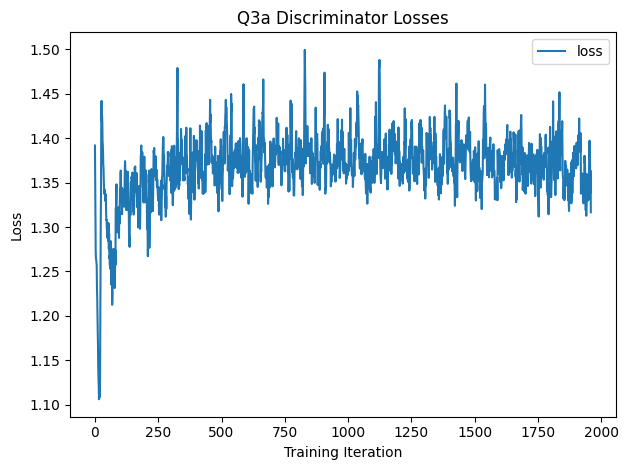

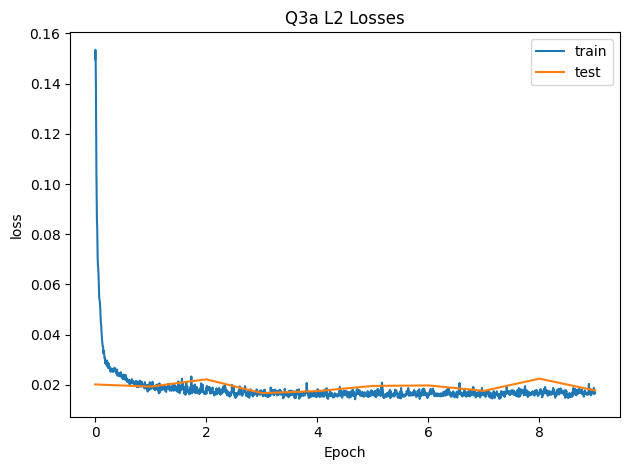

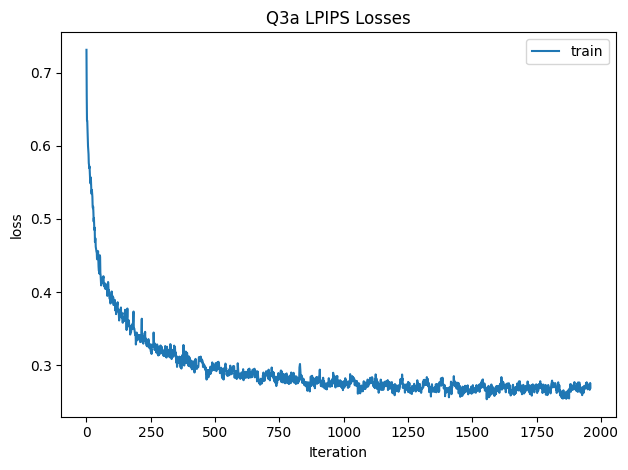

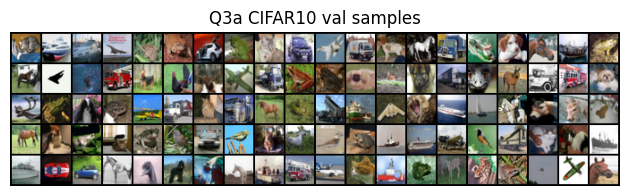

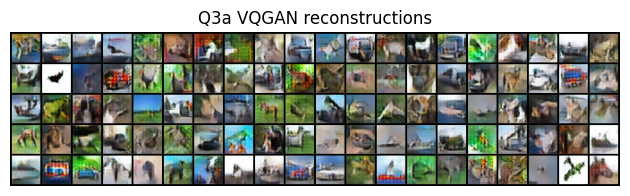

final_val_reconstruction_loss: 0.017783809453248978


In [ ]:
q3_save_results(q3a, "a") # with pips

## Part b: VIT-VQGAN [15]
In this part, you will replace the encoder and decoder in the VQGAN with a Vision Transformer (ViT) following the [Improved VQGAN paper](https://arxiv.org/abs/2110.04627). You may use pre-built ViT modules and/or transformers libraries for the purposes of this exercise. Split images into 4x4 patches which should give you 8x8 patches for each image.

**Discriminator**
In ViT-VQGAN, the patch-based discriminator is replaced with a full StyleGAN discriminator. For the purposes of this exercise, you should use the same discrimiator as described in part a but without splitting into patches. In addition add [spectral normalization](https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html#torch-nn-utils-spectral-norm) to all the conv and linear layers and use LeakyReLU instead of ReLU, following [SN-GANs](https://arxiv.org/abs/1802.05957). This is to help with training stability.
```
def Discriminator(*, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.LeakyReLU()
    global sum pooling
    nn.Linear(128, 1)
```
* in addition add

**Loss function**
$L = L_{VQ} + 0.1 L_{GAN} + \alpha L_{perceptual} + L_2 + 0.1 L_1$

The ViT-VQGAN paper introduces a new loss term $L_{Logit\_laplace}$ which is a logit laplace loss. For simplicity, we will use an L1 loss instead.

If you implemented the perceptual loss in the previous part, you can use the same perceptual loss here, otherwise you may keep $\alpha = 0$.


You should be able to largely be able to reuse your implementations in the previous part for this problem
The only 3 updates you need are:
* use ViT for encoder and decoder of VQVAE, use 4 layers, 8 heads, and 256 for the embedding size
* add L1 loss
* change the discrimiator to look at the full image

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.


In [ ]:
import tqdm
class MHA(nn.Module):
  def __init__(self, num_head = 4, model_dim = 128, vocab_dim = 128):
    super().__init__()
    self.q = nn.Linear(vocab_dim, model_dim)
    self.k = nn.Linear(vocab_dim, model_dim)
    self.v = nn.Linear(vocab_dim, model_dim)
    self.proj = nn.Linear(model_dim, vocab_dim)
    self.num_head = num_head
    self.model_dim = model_dim
    self.vocab_dim = vocab_dim

  def forward(self, x, mask, use_kv = False, k_cache = None, v_cache = None): # x: bs, seq_len, vocab_emb
    q = self.q(x).reshape(x.shape[0], x.shape[1], self.num_head, self.model_dim // self.num_head).transpose(1, 2)
    k = self.k(x).reshape(x.shape[0], x.shape[1], self.num_head, self.model_dim // self.num_head).transpose(1, 2)
    v = self.v(x).reshape(x.shape[0], x.shape[1], self.num_head, self.model_dim // self.num_head).transpose(1, 2) # bs, num_head, seq_len,  head_dim
    if use_kv and k_cache != None:
      k = torch.concat([k_cache, k], dim = 2)
      v = torch.concat([v_cache, v], dim = 2) # change k and v to new and full k, v
    else:
      if mask:
        mask = mask[:v.shape[-2], :v.shape[-2]]
    qk = torch.einsum('b n l d, b n j d -> b n l j', q, k) # b, n, l, l // if use cache qk.shape = b, n, 1, l + 1
    if mask:
      qk = qk + mask
    qk = torch.softmax(qk / (self.model_dim // self.num_head) ** 0.5, dim=-1)
    att = torch.einsum('b n l j, b n j d -> b n l d', qk, v) # b, n, l, d // use cache b, n, 1, d
    att = att.transpose(1, 2).reshape(x.shape[0], x.shape[1], self.model_dim) #b, l , dim
    att = self.proj(att) # b , l, vocab_dim
    if use_kv:
      return att, k, v # return new k and v
    return att

class Transformer_block(nn.Module):
  def __init__(self, heads, model_dim, vocab_dim):
    super().__init__()
    self.mha = MHA(heads, model_dim, vocab_dim)
    self.ffn = nn.Sequential(
      nn.Linear(vocab_dim, vocab_dim * 4),
      nn.GELU(),
      nn.Linear(vocab_dim * 4, vocab_dim)
    )
    self.ln1 = nn.LayerNorm(vocab_dim)
    self.ln2 = nn.LayerNorm(vocab_dim)
  def forward(self, x, mask, use_cache = False, k_cache = None, v_cache = None): # x: bs, seq_len, dim
    x = x
    if use_cache:
      cur_x, k, v = self.mha(self.ln1(x), mask, use_cache, k_cache, v_cache)
      x = x + cur_x
      x = x + self.ffn(self.ln2(x))
      return x, k, v
    else:
      x = x + self.mha(self.ln1(x), mask)
      x = x + self.ffn(self.ln2(x))
      return x

class Transformer(nn.Module):
  def __init__(self, heads = 4, layers = 2, model_dim = 128, max_seq_len=1024, vocab_size = 129, vocab_dim = 64, use_mask=True):
    super().__init__()
    self.use_mask = use_mask
    self.max_len = max_seq_len
    self.pos_emb = nn.Embedding(max_seq_len, vocab_dim)
    self.layers = nn.ModuleList()
    for _ in range(layers):
      self.layers.append(Transformer_block(heads, model_dim, vocab_dim))
    # self.out = nn.Linear(vocab_dim, vocab_size)

  def forward(self, x, use_cache = False, k_cache = None, v_cache = None):
    pos = self.pos_emb(torch.arange(0, self.max_len).to(x.device).unsqueeze(0)) #1, embed
    # print(x.shape, pos.shape)
    x = x + pos[:, :x.shape[1]] #bs, 64, 256
    if self.use_mask:
      mask = torch.tril(torch.ones(self.max_len, self.max_len)).to(x.device) #d,d
      mask[mask == 0] = -float('inf')
      mask[mask == 1] = 0
    else:
      mask = None
    if not use_cache:
      for layer in range(len(self.layers)):
        x = self.layers[layer](x, mask)
      # x = self.out(x)
      return x
    elif use_cache:
      cur_k_cache = []
      cur_v_cache = []
      mask = mask[k_cache[0].shape[2], :v_cache[0].shape[2]+1] # 1, seq_v+1
      for layer in range(len(self.layers)):
        if len(k_cache) != 0 and len(v_cache) != 0:
          x, k, v = self.layers[layer](x, mask, True, k_cache[layer], v_cache[layer])
        else:
          x, k, v = self.layers[layer](x, mask, True)
        cur_k_cache.append(k)
        cur_v_cache.append(v)
      # x = self.out(x)
      return x, cur_k_cache, cur_v_cache

In [ ]:
class vit_encoder(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.linear_proj = nn.Linear(4*4*3, dim)
    self.transformer = Transformer(use_mask=False, heads = 8, layers = 4, vocab_dim = 256, vocab_size = 256)

  def forward(self, x):
    b, c, w, h = x.shape
    x = x.reshape(b, c, 8, 4, 8, 4)
    x = x.permute(0, 2, 4, 1, 3, 5) #b, 8, 8, c, 4, 4
    x = x.reshape(b, 64, -1) #b, 64, c * 4 * 4
    x = self.linear_proj(x) #b, 64, 256
    x = self.transformer(x) #b, 64, 256
    return x

class vit_decoder(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.transformer = Transformer(use_mask=False, heads = 8, layers = 4, vocab_dim = 256, vocab_size = 256)
    self.layers = nn.Sequential(
        nn.ConvTranspose2d(dim, dim, 4, 2, 1), #4, 4 -> 8, 8
        nn.ReLU(),
        nn.ConvTranspose2d(dim, dim, 4, 2, 1), #8 ,8 -> 16 , 16
        nn.ReLU(),
        nn.Conv2d(dim, 3, 1, 1, 0),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.transformer(x)
    x = x.reshape(x.shape[0], 8, 8, -1).permute(0, 3, 1, 2)
    x = self.layers(x)
    return x

class residual_block_with_spectral(nn.Module):
  def __init__(self, dim_1, dim_2 = None):
    super().__init__()
    if dim_2 == None:
      dim_2 = dim_1
    self.net = nn.Sequential(
        nn.BatchNorm2d(dim_1),
        nn.ReLU(),
        nn.utils.spectral_norm(nn.Conv2d(dim_1, dim_2, 3, 1, 1)),
        nn.BatchNorm2d(dim_2),
        nn.ReLU(),
        nn.utils.spectral_norm(nn.Conv2d(dim_2, dim_2, 1, 1, 0))

    )
  def forward(self, x):
    x = self.net(x) + x
    return x


class discriminator(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.net = nn.Sequential(
      ResnetBlockDown(3, n_filters=n_filters, use_norm=True),
      ResnetBlockDown(128, n_filters=n_filters, use_norm=True),
      residual_block_with_spectral(n_filters,),
      residual_block_with_spectral(n_filters,),
      nn.LeakyReLU(),
      nn.AdaptiveAvgPool2d((1, 1))
    )
    # spectral normalization
    # global sum pooling
    self.out = nn.Sequential(
      nn.Linear(128, 1),
      nn.Sigmoid()
    )
  def forward(self, x):
    x = self.net(x).squeeze()
    x = self.out(x)
    if len(x.shape) == 1:
      x = x.unsqueeze(0)
    # print(x.shape)
    return x

class vit_vq_vae(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.encoder = vit_encoder(dim)
    self.decoder = vit_decoder(dim)
    self.codebook = nn.Embedding(1024, 256)
    self.codebook.weight.data.uniform_(-1/1024, 1/1024)

In [ ]:
def q3b(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.
    """

    """ YOUR CODE HERE """
    import tqdm
    epoch = 75
    bs = 512
    lr = 1e-4
    dim = 256
    mse = torch.nn.MSELoss()
    bce = torch.nn.BCELoss()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    model = vit_vq_vae(dim).to(device)
    dis = discriminator(128).to(device)
    lpips = LPIPS().to(device)
    l1 = nn.L1Loss()
    optim_dis = torch.optim.Adam(dis.parameters(), lr=lr)
    optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
    train_tensor = torch.from_numpy(train_data)[:].to(device)
    test_tensor = torch.from_numpy(val_data).to(device)
    train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=bs)
    test_loader = torch.utils.data.DataLoader(test_tensor, batch_size=bs)
    discriminator_losses = []
    l_pips_losses = []
    l2_recon_train = []
    l2_recon_test = []
    def find_in_cb(z):
      # z_flat = z.permute(0, 2, 3, 1).reshape(-1, dim)
      z_flat = z.reshape(-1, dim) # bs, 64, 256
      z_sqr = torch.sum(z_flat ** 2, dim=1, keepdim=True)
      cb_sqr = torch.sum(model.codebook.weight ** 2, dim=1, keepdim=True).permute(1,0) #1, 1024
      cal_2_z_cb = -2 * z_flat @ model.codebook.weight.T
      dist = z_sqr + cb_sqr + cal_2_z_cb #bs * 64, 256
      return dist
    def test(data=None):
      model.eval()
      with torch.no_grad():
        def reconstruct(test_data):
          z = model.encoder(test_data)
          dist = find_in_cb(z)
          index = torch.argmin(dist, dim = 1)
          z_q = model.codebook.weight[index]
          z_q = z_q.reshape(*z.shape)
          recon = model.decoder(z_q)
          return recon

        if data == None:
          loop = tqdm.tqdm(test_loader)
          total_loss = 0
          for d in loop:
            test_data = d.float().to(device)
            reconstruct_data = reconstruct(test_data)
            cur_loss = mse(reconstruct_data, test_data)
            total_loss += cur_loss
            loop.set_postfix({'loss': cur_loss.item()})
          return total_loss / len(test_loader)
        else:
          reconstruct_data = reconstruct(data)
          return reconstruct_data
    for i in range(epoch):
      model.train()
      loop = tqdm.tqdm(train_loader)
      for data in loop:
        optim.zero_grad()
        optim_dis.zero_grad()
        real_data = data.float().to(device)
        z = model.encoder(real_data)
        dist = find_in_cb(z)
        index = torch.argmin(dist, dim = 1)
        z_q = model.codebook.weight[index]
        z_q = z_q.reshape(*z.shape)
        # z_q = z_q.reshape(b, w, h, c).permute(0, 3, 1, 2)
        # print(z_q.shape, z.shape)
        z_q_with_grad = (z_q - z).detach() + z
        reconstruct = model.decoder(z_q_with_grad)
        code_book_loss = mse(z_q, z.detach())
        commit_loss = mse(z_q.detach(), z)
        recon_loss = mse(reconstruct, real_data)
        #train_dis
        dis_out = dis(real_data)
        real_lables = torch.ones(dis_out.shape[0]).to(device).unsqueeze(1)
        fake_lables = torch.zeros(dis_out.shape[0]).to(device).unsqueeze(1)
        # if len(dis_out.shape) == 1:
        #   dis_out = dis_out.unsqueeze(0)
        #   print(dis_out.shape, real_lables.shape)

        dis_loss_real = bce(dis_out, real_lables)
        dis_loss_fake = bce(dis(reconstruct.detach()), fake_lables)
        dis_loss = dis_loss_real + dis_loss_fake
        dis_loss.backward()
        optim_dis.step()
        #trian_vae
        dis_loss_vae = bce(dis(reconstruct), real_lables)
        loss_l = lpips(reconstruct, real_data).mean()
        loss_l1 = l1(reconstruct, real_data)
        # Loss function  𝐿=𝐿𝑉𝑄+0.1𝐿𝐺𝐴𝑁+𝛼𝐿𝑝𝑒𝑟𝑐𝑒𝑝𝑡𝑢𝑎𝑙+𝐿2+0.1𝐿1
        loss = (code_book_loss + commit_loss * 0.25) + recon_loss + 0.1 * dis_loss_vae + 0.5 * loss_l + 0.1 * loss_l1
        loop.set_postfix({'loss':loss.item(), 'dis_loss':dis_loss.item(), 'epoch': i})
        loss.backward()
        optim.step()

        discriminator_losses.append(dis_loss.item())
        l_pips_losses.append(loss_l.item())
        l2_recon_train.append(recon_loss.item())
      l2_recon_test.append(test().item())

    #reconstruct
    model.eval()
      # with torch.no_grad():
    reconstructions = test(torch.from_numpy(reconstruct_data).to(device).float())
    reconstructions = reconstructions.cpu().permute(0, 2, 3, 1)
    reconstructions = reconstructions.numpy()
    discriminator_losses = np.array(discriminator_losses)
    # print(reconstructions.shape)
    # l_pips_losses = np.array(l_pips_losses)
    # l2_recon_train = np.array(l2_recon_train)
    # l2_recon_test = np.array(l2_recon_test)
    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


100%|██████████| 20/20 [00:02<00:00,  8.13it/s, loss=0.0265]


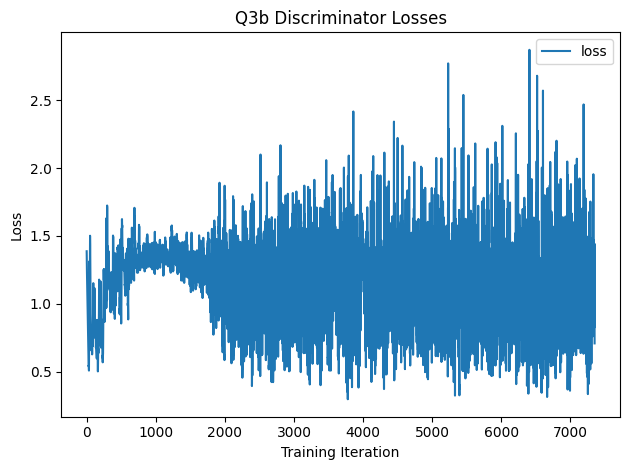

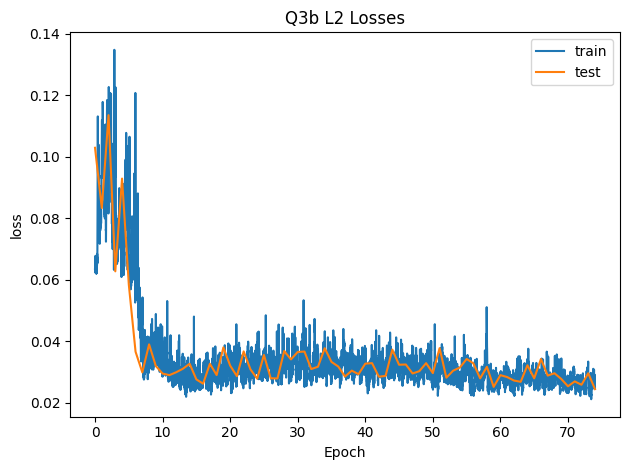

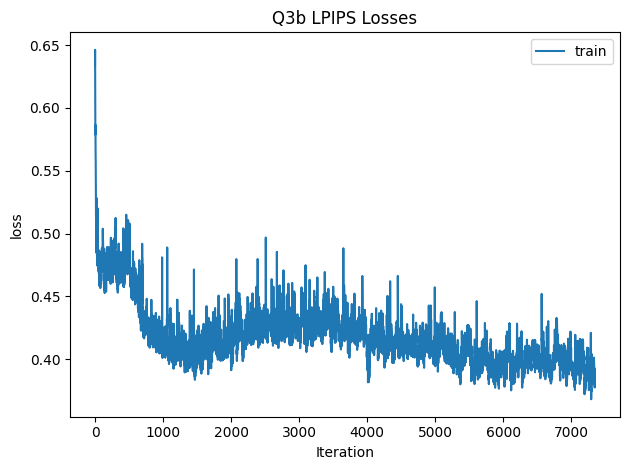

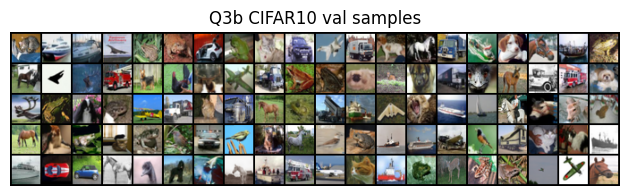

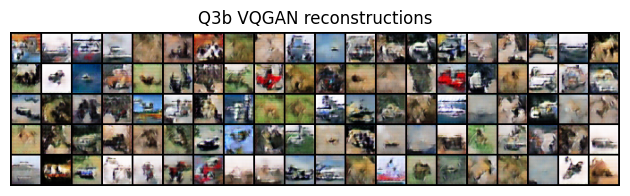

final_val_reconstruction_loss: 0.024475116282701492


In [ ]:
q3_save_results(q3b, "b")

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST.

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain.

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models.

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain.
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions.

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
q4_save_results(q4)